In [2]:
library(opploansanalytics)
load.packages()

RPostgreSQL    RPostgres        RJDBC         httr     jsonlite googlesheets 
        TRUE         TRUE         TRUE         TRUE         TRUE         TRUE 
   tidyverse        tidyr        dplyr    lubridate      stringr      ggplot2 
        TRUE         TRUE         TRUE         TRUE         TRUE         TRUE 
      ggpubr      cowplot        rJava        mailR     devtools     roxygen2 
        TRUE         TRUE         TRUE         TRUE         TRUE         TRUE

In [3]:
getLeads = function (admethod) {
    
    queryReporting(paste0(
"
select
    lde.lead_id
    , lde.lead_time
    , lde.raw_lead ->> 'campaign_id' as campaign_id
    , lde.accepted
    , p_ap.denygrp
from
    lde4.leads as lde
    inner join
        cloudlending.advertising_method as c_adm
        on lde.partnerid = c_adm.external_id
        and c_adm.name = '" ,admethod, "'
    left join
        cloudlending.applications as c_app
        on lde.lead_id = c_app.lde4_lead_id
    left join
        public.all_allapps as p_ap
        on c_app.name = p_ap.loanid
where
    lde.lead_time >= '2020-01-01'::date       
"
    )) %>% 
    mutate(
        lead.day = lead_time %>% as.Date(),
        app = !is.na(denygrp),
        qualified = !is.na(denygrp) & !denygrp %in% c('1BusRle', '2Bureau'),
        funded = !is.na(denygrp) & denygrp == '9Apprve'
    )
    
}

In [4]:
plotLeadMetrics = function (admethod.df, admethod.name, metric.quo, coord.ratio = 200) {
    
    theme_set(theme_bw())
    admethod.df %>% 
        group_by(
            lead.day
        ) %>% 
        summarize(
            accept.rate = sum(accepted)/n(),
            app.rate = sum(app)/sum(accepted),
            qualified.rate = sum(qualified)/sum(app),
            funding.rate = sum(funded)/sum(qualified),
            accept.to.fund = sum(funded)/sum(accepted)
        ) %>% 
        ggplot(
            mapping = aes(
                x = lead.day,
                y = !!metric.quo
            )
        ) +
        geom_point(
            color = case_when(
                quo_name(metric.quo) == 'funding.rate' ~ '#F8766D',
                quo_name(metric.quo) == 'qualified.rate' ~ '#00B81F',
                quo_name(metric.quo) == 'app.rate' ~ '#BB9D00',
                quo_name(metric.quo) == 'accept.rate' ~ '#00A5FF',
                quo_name(metric.quo) == 'accept.to.fund' ~ '#AC88FF',
            )
        ) +
        geom_line(
            color = case_when(
                quo_name(metric.quo) == 'funding.rate' ~ '#F8766D',
                quo_name(metric.quo) == 'qualified.rate' ~ '#00B81F',
                quo_name(metric.quo) == 'app.rate' ~ '#BB9D00',
                quo_name(metric.quo) == 'accept.rate' ~ '#00A5FF',
                quo_name(metric.quo) == 'accept.to.fund' ~ '#AC88FF',
            )
        ) +
        scale_y_continuous(
            labels = scales::percent
        ) +
        labs(
            title = paste(
                admethod.name,
                '-',
                quo_name(metric.quo) %>% 
                    str_replace_all(
                        pattern = "\\.",
                        replacement = " "
                    ) %>% 
                    str_to_title(
                    )
            )
#         ) +
#         coord_fixed(
#             coord.ratio
        )
    
}

In [5]:
getAllPlots = function (admethod.name) {
    
    metrics = c(
        'funding.rate',
        'qualified.rate',
        'app.rate',
        'accept.rate',
        'accept.to.fund'
    )
    
    assign(
        x = admethod.name,
        value = getLeads(admethod.name),
        envir = .GlobalEnv
    )
    
    
    list(
        funding.rate = get(admethod.name) %>%
            plotLeadMetrics(
                admethod.name = admethod.name,
                metric.quo = quo(funding.rate)
            ),
        
        qualified.rate = get(admethod.name) %>%
            plotLeadMetrics(
                admethod.name = admethod.name,
                metric.quo = quo(qualified.rate)
            ),
        
        app.rate = get(admethod.name) %>%
            plotLeadMetrics(
                admethod.name = admethod.name,
                metric.quo = quo(app.rate)
            ),
        
        accept.rate = get(admethod.name) %>%
            plotLeadMetrics(
                admethod.name = admethod.name,
                metric.quo = quo(accept.rate)
            ),
        
        accept.to.fund = get(admethod.name) %>%
            plotLeadMetrics(
                admethod.name = admethod.name,
                metric.quo = quo(accept.to.fund)
            )
        
    )
    
}

# End Metrics

In [6]:
lenderedge = getAllPlots('LenderEdge 4')
# monevo = getAllPlots('Monevo')
# evenfinancial = getAllPlots('Even Financial 4')
# leadgroup = getAllPlots('LeadGroup')
# leaptheory = getAllPlots('LeapTheory 4')
# leadzoom = getAllPlots('LeadZoom 4')
# barrelhead = getAllPlots('Barrelhead 4')
# personalloans = getAllPlots('PersonalLoans.com 4')

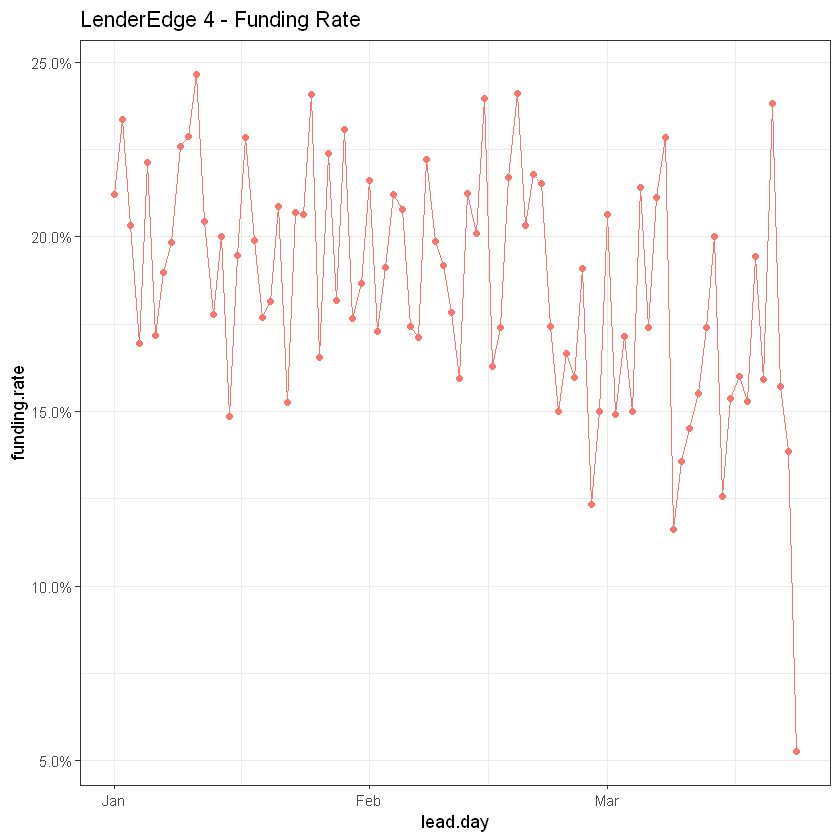

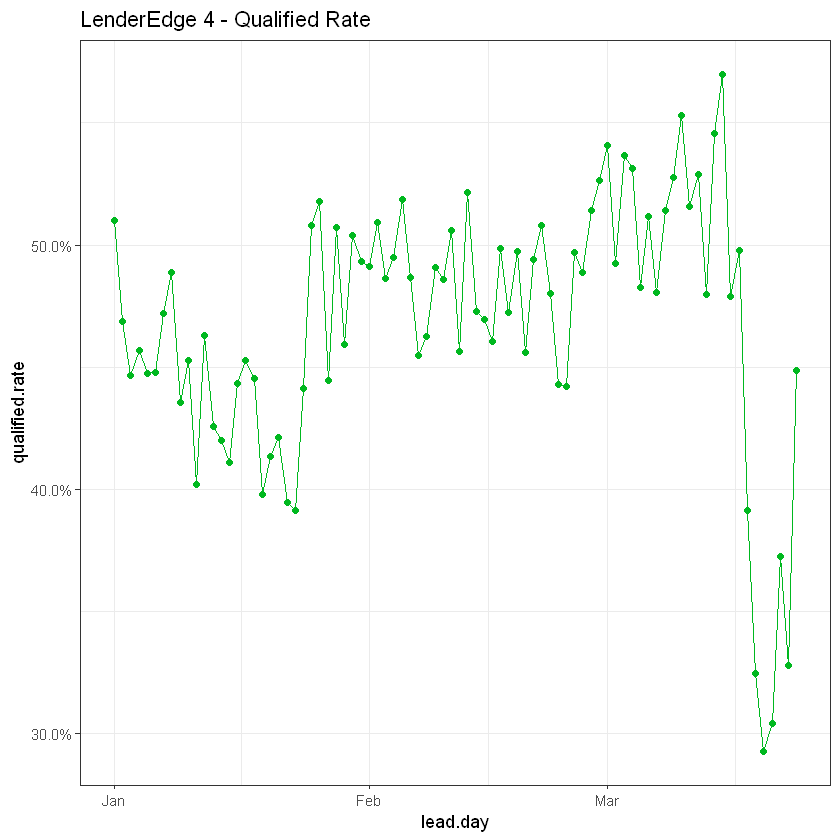

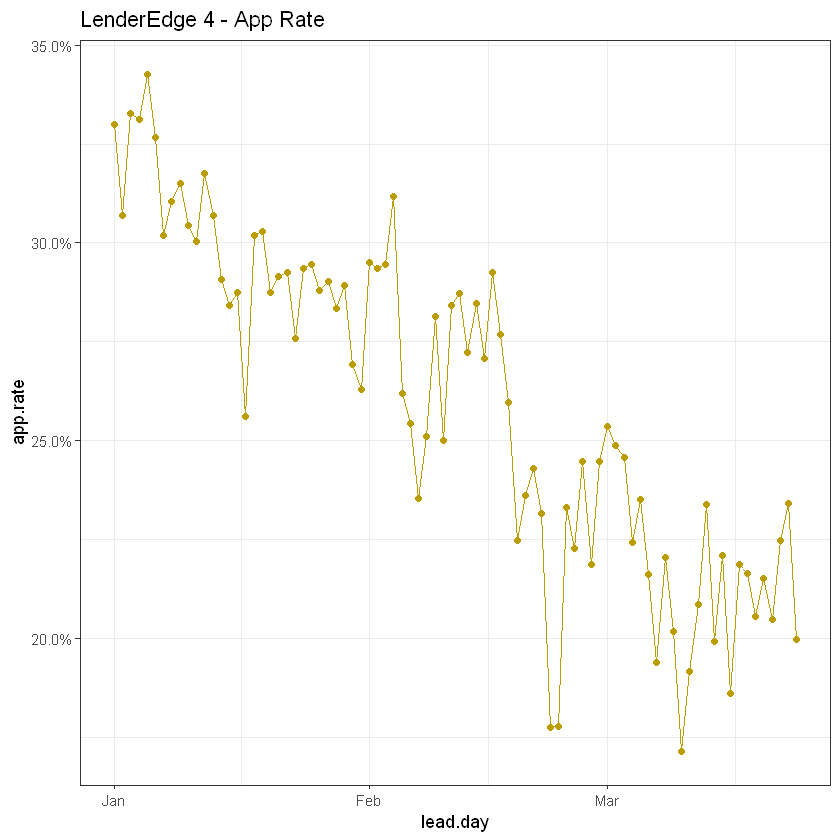

$funding.rate

$qualified.rate

$app.rate

$accept.rate

$accept.to.fund


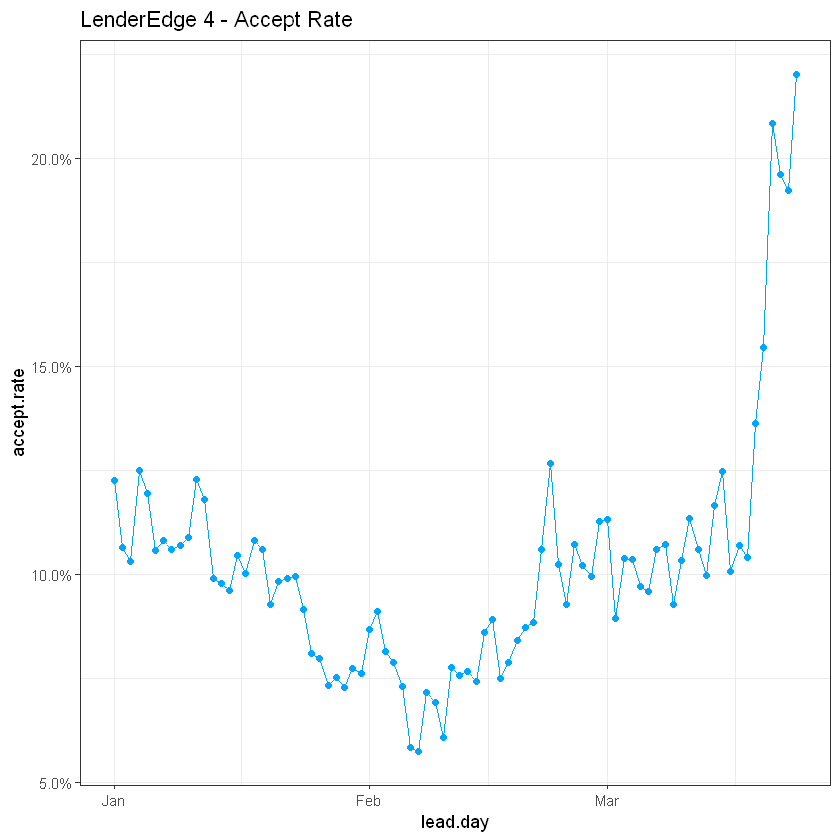

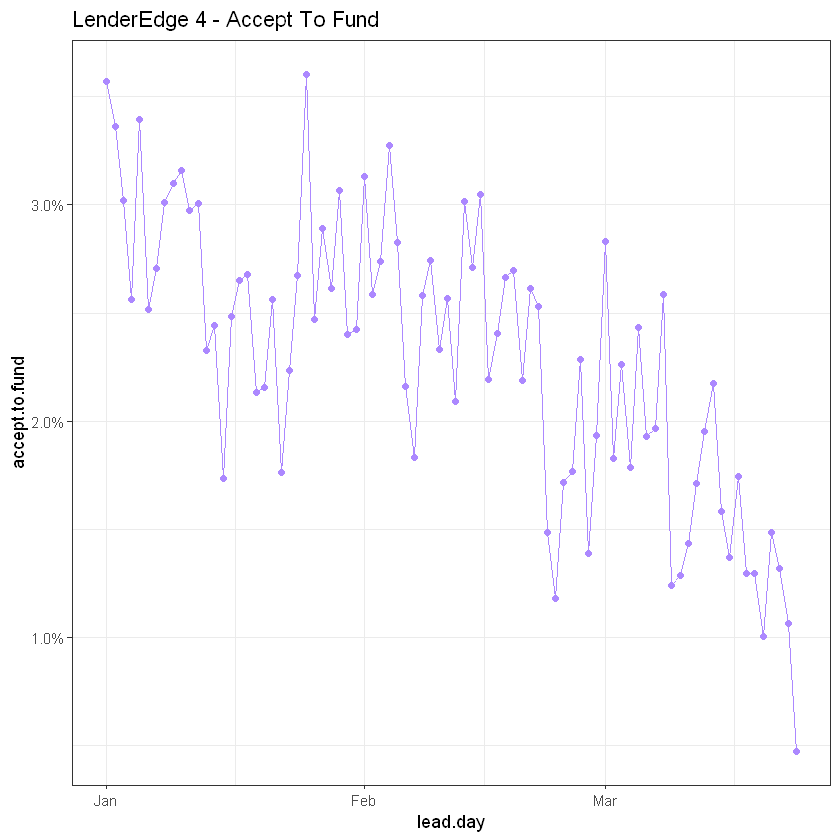

In [7]:
lenderedge
# monevo
# evenfinancial
# leadgroup
# leaptheory
# leadzoom
# barrelhead
# personalloans

# Payload Validations

### Get Payloads

In [ ]:
getPayloads = function (timestart = '2020-02-28', timeend = '2020-03-02', admethod, limit = NA) {
    
    queryReporting(paste0(
    "
    select
        *
    from
        lde4.leads as lde
        inner join
            cloudlending.advertising_method as c_adm
            on lde.partnerid = c_adm.external_id
            and c_adm.name = '", admethod, "'
    where
        lde.lead_time >= '", timestart, "'::date
        and lde.lead_time < '", timeend, "'::date
    ", ifelse(is.na(limit), "", paste0("limit ", limit)), "
    "
    ))
    
}

In [ ]:
lenderedge.payloads = getPayloads(timestart = '2020-02-15', timeend = '2020-02-20', admethod = 'LenderEdge 4')
# evenfinancial.payloads = getPayloads(timestart = '2020-03-17', timeend = '2020-03-18', admethod = 'Even Financial 4')
# monevo.payloads = getPayloads(admethod = 'Monevo')
# leadgroup.payloads = getPayloads(timestart = '2020-03-17', timeend = '2020-03-18', admethod = 'LeadGroup')
# leaptheory.payloads = getPayloads(admethod = 'LeapTheory 4')
# leadzoom.payloads = getPayloads(admethod = 'LeadZoom 4')
# barrelhead.payloads = getPayloads(admethod = 'Barrelhead 4')
# personalloans.payloads = getPayloads(admethod = 'PersonalLoans.com 4')

### Confirm Changes
- LenderEdge <b>did not</b> actually change how they handle null values.
- LeadZoom <b>did</b> change how they pass quoted booleans. 
- PersonalLoans.com <b>did</b> change how they handle null values. 
- Barrelhead <b>did</b> change how they pass quoted integers. 

In [ ]:
# lenderedge.payloads %>%
#     mutate(
#         check = raw_lead %>% 
#             map(
#                 .f = ~ .x %>% 
#                     str_match_all(
#                         "\\\"payrollType\\\":\\s?(.*?)[,\\}]"
# #                         "\\\"payrollFrequency\\\":\\s?(.*?)[,\\}]"
# #                         "\\\"lastPayrollDate\\\":\\s?(.*?)[,\\}]"
# #                         "\\\"mobilePhone\\\":\\s?(.*?)[,\\}]"
#                     ) %>% .[[1]] %>% .[,2]
#             ) %>% as.character()
#     ) %>% 
#     group_by(
#         check
# #         nchar(check)
#     ) %>% 
#     summarize(
#         n = n()
#     )

In [ ]:
# evenfinancial.payloads %>%
#     mutate(
#         check = raw_lead %>% 
#             map(
#                 .f = ~ .x %>% 
#                     str_match_all(
#                         "\\\"payrollType\\\":\\s?(.*?)[,\\}]"
# #                         "\\\"payrollFrequency\\\":\\s?(.*?)[,\\}]"
# #                         "\\\"mobilephone\\\":\\s?(.*?)[,\\}]"
#                     ) %>% .[[1]] %>% .[,2]
#             ) %>% as.character()
#     ) %>% 
#     group_by(
#         check
# #         nchar(check)
#     ) %>% 
#     summarize(
#         n = n()
#     )

In [ ]:
# monevo.payloads %>%
#     mutate(
#         check = raw_lead %>% 
#             map(
#                 .f = ~ .x %>% 
#                     str_match_all(
# #                         "\\\"homephone\\\":\\s?(.*?)[,\\}]"
#                         "\\\"payrollFrequency\\\":\\s?(.*?)[,\\}]"
# #                         "\\\"requestedLoanAmount\\\":\\s?(.*?)[,\\}]"
#                     ) %>% .[[1]] %>% .[,2]
#             ) %>% as.character()
#     ) %>% 
#     group_by(
#         check
# #         nchar(check)
#     ) %>% 
#     summarize(
#         n = n()
#     )

In [ ]:
# leadgroup.payloads %>%
#     mutate(
#         check = raw_lead %>% 
#             map(
#                 .f = ~ .x %>% 
#                     str_match_all(
#                         "\\\"isProduction\\\":\\s?(.*?)[,\\}]"
# #                         "\\\"incomeType\\\":\\s?(.*?)[,\\}]"
# #                         "\\\"employerName\\\":\\s?(.*?)[,\\}]"
#                     ) %>% .[[1]] %>% .[,2]
#             ) %>% as.character()
#     ) %>% 
#     group_by(
#         check
# #         nchar(check)
#     ) %>% 
#     summarize(
#         n = n()
#     )

In [ ]:
# leaptheory.payloads %>%
#     mutate(
#         check = raw_lead %>% 
#             map(
#                 .f = ~ .x %>% 
#                     str_match_all(
# #                         "\\\"accountType\\\":\\s?(.*?)[,\\}]"
#                         "\\\"accountLength\\\":\\s?(.*?)[,\\}]"
#                     ) %>% .[[1]] %>% .[,2]
#             ) %>% as.character()
#     ) %>% 
#     group_by(
#         check
# #         nchar(check)
#     ) %>% 
#     summarize(
#         n = n()
#     )

In [ ]:
# leadzoom.payloads %>%
#     mutate(
#         check = raw_lead %>% 
#             map(
#                 .f = ~ .x %>% 
#                     str_match_all(
#                         "\\\"isProduction\\\":\\s?(.*?)[,\\}]"
#                     ) %>% .[[1]] %>% .[,2]
#             ) %>% as.character()
#     ) %>% 
#     group_by(
#         check
# #         nchar(check)
#     ) %>% 
#     summarize(
#         n = n()
#     )

In [ ]:
# barrelhead.payloads %>%
#     mutate(
#         check = raw_lead %>% 
#             map(
#                 .f = ~ .x %>% 
#                     str_match_all(
#                         "\\\"payrollFrequency\\\":\\s?(.*?)[,\\}]"
# #                         "\\\"grossMonthlyIncome\\\":\\s?(.*?)[,\\}]"
# #                         "\\\"requestedLoanAmount\\\":\\s?(.*?)[,\\}]"
#                     ) %>% .[[1]] %>% .[,2]
#             ) %>% as.character()
#     ) %>% 
#     group_by(
#         check
# #         nchar(check)
#     ) %>% 
#     summarize(
#         n = n()
#     )

In [ ]:
# personalloans.payloads %>%
#     mutate(
#         check = raw_lead %>% 
#             map(
#                 .f = ~ .x %>% 
#                     str_match_all(
#                         "\\\"bankName\\\":\\s?(.*?)[,\\}]"
# #                         "\\\"accountType\\\":\\s?(.*?)[,\\}]"
# #                         "\\\"accountLength\\\":\\s?(.*?)[,\\}]"
# #                         "\\\"accountNumber\\\":\\s?(.*?)[,\\}]"
# #                         "\\\"abaRoutingNumber\\\":\\s?(.*?)[,\\}]"
# #                         "\\\"lastPayrollDate\\\":\\s?(.*?)[,\\}]"
#                     ) %>% .[[1]] %>% .[,2]
#             ) %>% as.character()
#     ) %>% 
#     group_by(
# #         check
#         nchar(check)
#     ) %>% 
#     summarize(
#         n = n()
#     )

### Validating Parsing

# Reg Validations

In [ ]:
getRegInputsAll = function (start.date = '2020-02-01', end.date = '2020-03-01', partner_id = NA, limit = NA) {
        
    raw.query = querySnowflake(paste0(
        "
        select
            reg.event_id
            , reg.session_id
            , reg.user_id
            , users_.\"identity\" as contact
            , reg.\"time\"
            , reg.email
            , reg.partner_id
            , reg.neededinputs
        from
            heap_prod.heap._viewed_lead_registration_ as reg
            inner join
                ods_prod.cloudlending.advertising_method__c as c_am
                on reg.partner_id = c_am.external_id__c
                ", ifelse(is.na(partner_id), "", paste0("and c_am.external_id__c = ", partner_id)), "
            left join
                heap_prod.heap.users as users_
                on reg.user_id = users_.user_id
        where
            reg.\"time\" >= '", start.date, "'::date
            and reg.\"time\" < '", end.date, "'::date
        ", ifelse(is.na(limit), "", paste0("limit ", limit))
    ))
    colnames(raw.query) %<>% str_to_lower()
    
    
    raw.query %>%
        mutate(
            fields = neededinputs %>%
                map(
                    .f = function (x) {
                        x %>%
                            str_match_all(
                                pattern = regex('registration\\[(.*?)\\]')
                            ) %>%
                            .[[1]] %>% .[ ,2]
                    }
                )
        )
    
    
}

In [ ]:
# lenderedge.reg = getRegInputsAll(partner_id = 349)

In [ ]:
lenderedge.payloads %>% 
    filter(
        accepted
    ) %>% 
    left_join(
        lenderedge.reg,
        by = 'email'
    ) %>% 
    group_by(
        lead.day = lead_time %>% as.Date()
    ) %>% 
    summarize(
        count.total = n(),
        count.view.reg = sum(!is.na(event_id)),
        perc.view.reg = count.view.reg/count.total
    ) %>% 
    ungroup() %>% 
    ggplot(
        mapping = aes(
            x = lead.day,
            y = perc.view.reg
        )
    ) +
    geom_point(aes(color = '#CF78FF')) +
    geom_line(aes(color = '#CF78FF')) +
    scale_y_continuous(
        labels = scales::percent
    ) +
    labs(
        title = 'LenderEdge 4: Viewed Reg/Accepted Lead',
        y = 'Conversion',
        x = 'Day'
    ) +
    coord_fixed(
        10
    )